# Multivariate to each input/output Time Series

In [8]:
import numpy as np
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [9]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'
start_date='2016-01-01'
end_date='2022-12-31'



# EMA2 and Signal

my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
#my_features=['Price', 'EMA1','EMA2','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself

n_early=10

train_ratio=0.8


n_batch=32
n_epochs=100


main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


# 10 predict 1 
# 60 predict 1
n_input =60
# define generator

n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

tune_folder='multivar_tune'


seed=7


input=60 and features=8


# Load Data

In [10]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1702 entries, 2016-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1702 non-null   float64
 1   EMA1    1702 non-null   float64
 2   EMA2    1702 non-null   float64
 3   EMA3    1702 non-null   float64
 4   MACD    1702 non-null   float64
 5   SIGNAL  1702 non-null   float64
 6   RSI     1702 non-null   float64
 7   RSI-MA  1702 non-null   float64
dtypes: float64(8)
memory usage: 119.7 KB
None
              Price    EMA1    EMA2    EMA3  MACD  SIGNAL    RSI  RSI-MA
Date                                                                    
2022-12-28  1000.54  985.80  983.87  983.87  1.92   -0.09  65.03   54.98
2022-12-29  1010.19  990.23  986.38  986.38  3.85    0.41  69.99   59.54
2022-12-30  1005.24  992.96  988.17  988.17  4.79    0.95  64.93   63.01


# Tranform Data

In [11]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(1702, 8)
0.8 of 1702 = The number of train data is 1362
(1362, 8) (340, 8)
(1362, 8) (340, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.46663119 0.4176142  0.38593197 0.38593197 0.62184124 0.59529992
  0.35929131 0.26231672]
 [0.43983734 0.41301347 0.38167112 0.38167112 0.618571   0.59478058
  0.26768301 0.26480938]]
[[0.62731833 0.56479352 0.52146073 0.52146073 0.72966009 0.69163854
  0.71817058 0.57815249]
 [0.61791198 0.57077446 0.52576972 0.52576972 0.73897532 0.6986497
  0.64867463 0.62903226]]


# Generate Timeseries For LSTM

In [12]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 1302
(1, 60, 8) (1, 8)
[[[0.21830344 0.17640486 0.13540839 0.13540839 0.56198593 0.50727084
   0.15973081 0.20249267]
  [0.20076391 0.1655603  0.12616451 0.12616451 0.55098603 0.50662166
   0.12621893 0.17800587]
  [0.20893509 0.15839632 0.1187983  0.1187983  0.54890496 0.5057128
   0.16632331 0.16143695]
  [0.15521435 0.1412641  0.10565465 0.10565465 0.52561689 0.50116853
   0.07636314 0.12947214]
  [0.18586576 0.13368386 0.0974459  0.0974459  0.5251214  0.49701376
   0.20120863 0.12052786]
  [0.17053056 0.12426334 0.08817794 0.08817794 0.52066198 0.49272916
   0.17470128 0.12360704]
  [0.20154302 0.12305839 0.08353193 0.08353193 0.53433753 0.49117112
   0.28416426 0.15733138]
  [0.23531088 0.12917077 0.08341157 0.08341157 0.56248142 0.49441703
   0.38387584 0.20381232]
  [0.20872606 0.12857925 0.08008955 0.08008955 0.57348132 0.49909115
   0.32715286 0.25733138]
  [0.17746656 0.12154672 0.07330108 0.07330108 0.56951739 0.50246689
   0.26878176 0.27184751]
  [0.17414108 0.115

# LSTM Train

In [13]:
#neuron_number=100

np.random.seed(7)
neuron_number=n_input* n_features
neuron_number=60
print(f"{neuron_number}= {n_input} x {n_features} (univariate n_features=1)")

model = Sequential()

model.add(LSTM(neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features)))  

model.add(Dense(n_output))

#https://keras.io/api/metrics/
# model.compile(optimizer="adam", loss="mean_squared_error")
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

60= 60 x 8 (univariate n_features=1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                16560     
                                                                 
 dense_1 (Dense)             (None, 8)                 488       
                                                                 
Total params: 17,048
Trainable params: 17,048
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)

# n_early=0
if (n_early>0):
 print("fit by early stop")   
 history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,callbacks=[early_stop],verbose=1)
else:
   history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,verbose=1)   


fit by early stop
Epoch 1/100
1302/1302 [==============================] - 19s 13ms/step - loss: 0.0093
Epoch 2/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0049
Epoch 3/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0042
Epoch 4/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0032
Epoch 5/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0021
Epoch 6/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0016
Epoch 7/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0014
Epoch 8/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0013
Epoch 9/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0012
Epoch 10/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0012
Epoch 11/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0012
Epoch 12/100
1302/1302 [==========

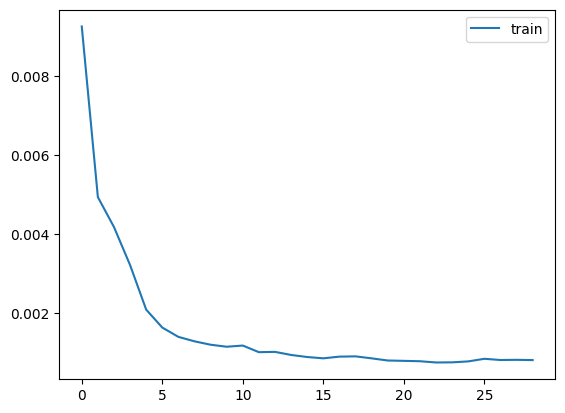

In [16]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [17]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 1302


In [18]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 340 + 60 to predict = (400, 8)
(400, 8)
(400, 8)
[[0.39979598 0.31721968 0.31755808 0.31755808 0.35351003 0.33826638
  0.54722062 0.4088748 ]
 [0.38033584 0.32589626 0.32123177 0.32123177 0.3739255  0.3435518
  0.52567802 0.41408196]]


In [19]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(340, 60, 8)
[[[0.39979598 0.31721968 0.31755808 0.31755808 0.35351003 0.33826638
   0.54722062 0.4088748 ]
  [0.38033584 0.32589626 0.32123177 0.32123177 0.3739255  0.3435518
   0.52567802 0.41408196]
  [0.34565286 0.32532418 0.32004322 0.32004322 0.37571633 0.34830867
   0.48720908 0.46139914]
  [0.23407094 0.3002479  0.30437601 0.30437601 0.33345272 0.34460888
   0.37468744 0.44690967]
  [0.23681733 0.28032037 0.29054565 0.29054565 0.30444126 0.33615222
   0.37814964 0.41385556]
  [0.23924984 0.26449275 0.27833603 0.27833603 0.28545845 0.3255814
   0.38122716 0.3746887 ]
  [0.31677652 0.26878337 0.27747164 0.27747164 0.30444126 0.3192389
   0.48028467 0.364048  ]
  [0.27440364 0.26287185 0.2710967  0.2710967  0.30336676 0.31395349
   0.43239084 0.35114331]
  [0.233914   0.24904653 0.26007563 0.26007563 0.28796562 0.30655391
   0.38815157 0.35431288]
  [0.22779347 0.23646072 0.24927066 0.24927066 0.2765043  0.29756871
   0.3814195  0.35521847]
  [0.20660703 0.22139588 0.2367369  0.23

# Prediction

In [20]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

11/11 [==============================] - 0s 9ms/step
Before Invert : (340, 8)


array([[0.21511394, 0.09463221, 0.03480421, 0.04037558, 0.51917994,
        0.22320431, 0.28096786, 0.2106812 ],
       [0.20439878, 0.08234041, 0.01923071, 0.02511739, 0.5291382 ,
        0.22264779, 0.25002992, 0.20562792],
       [0.26191553, 0.10882509, 0.03134974, 0.04774163, 0.5792196 ,
        0.22762188, 0.37456194, 0.2536586 ]], dtype=float32)

In [21]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (340, 8)


array([[935.9141   , 928.61505  , 927.18115  , 927.6968   ,   3.235504 ,
         -3.7869744,  38.567516 ,  39.03579  ],
       [934.5486   , 927.32587  , 925.7398   , 926.28467  ,   3.5135388,
         -3.797504 ,  36.959057 ,  38.812584 ],
       [941.8785   , 930.1036   , 926.86145  , 928.3785   ,   4.911811 ,
         -3.703394 ,  43.433475 ,  40.9341   ]], dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        340 non-null    float64
 1   Price-Pred   340 non-null    float32
 2   EMA1         340 non-null    float64
 3   EMA1-Pred    340 non-null    float32
 4   EMA2         340 non-null    float64
 5   EMA2-Pred    340 non-null    float32
 6   EMA3         340 non-null    float64
 7   EMA3-Pred    340 non-null    float32
 8   MACD         340 non-null    float64
 9   MACD-Pred    340 non-null    float32
 10  SIGNAL       340 non-null    float64
 11  SIGNAL-Pred  340 non-null    float32
 12  RSI          340 non-null    float64
 13  RSI-Pred     340 non-null    float32
 14  RSI-MA       340 non-null    float64
 15  RSI-MA-Pred  340 non-null    float32
dtypes: float32(8), float64(8)
memory usage: 32.0 KB
None


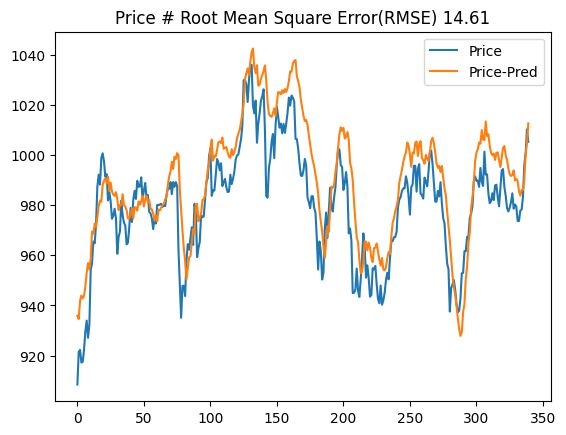

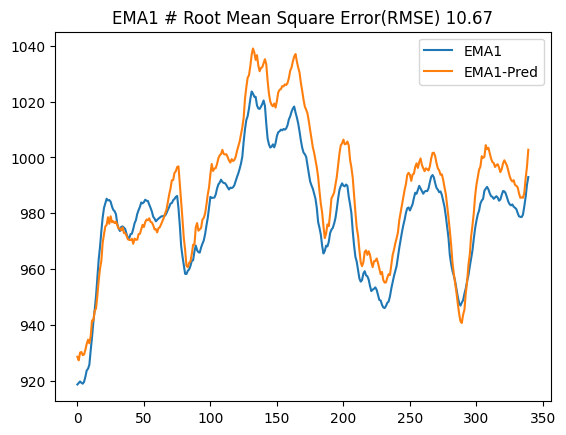

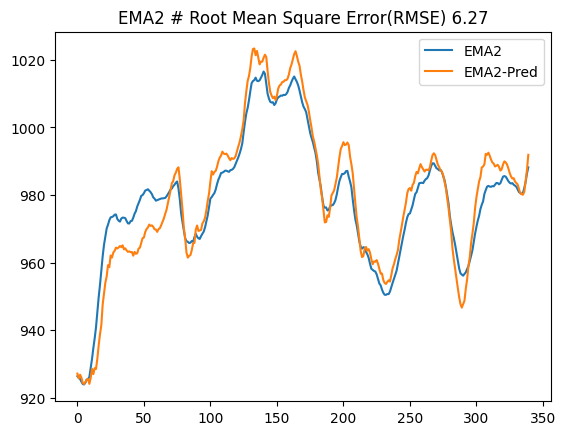

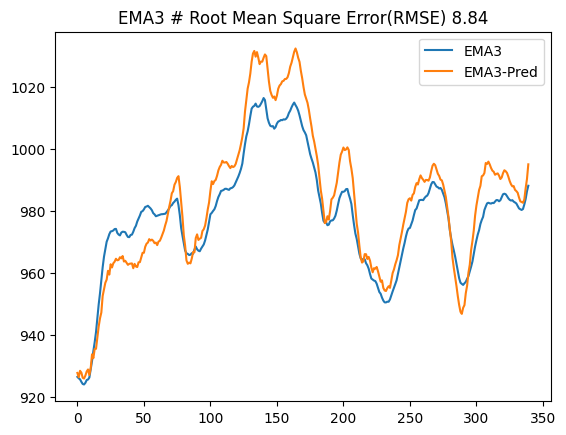

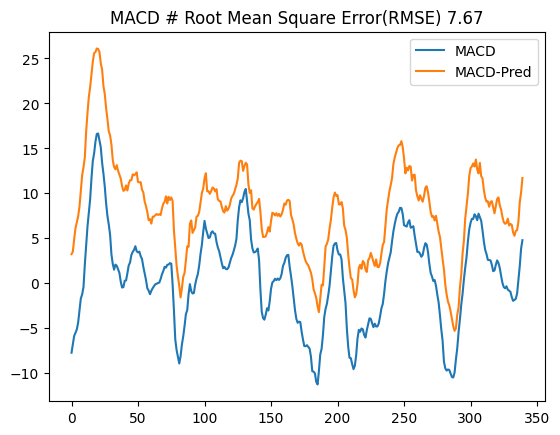

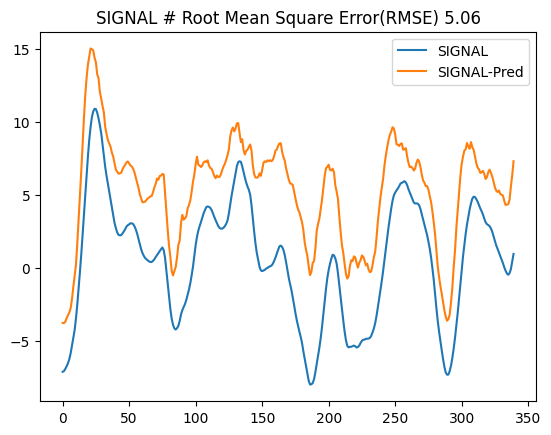

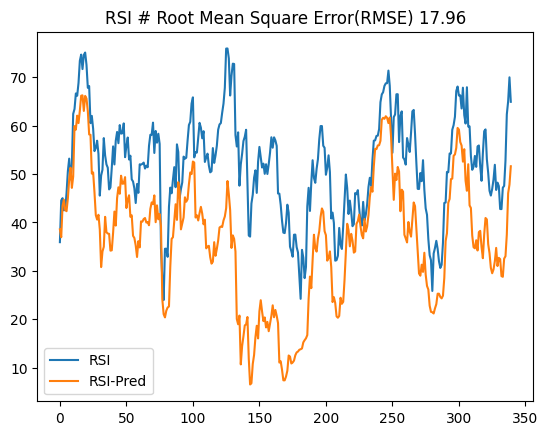

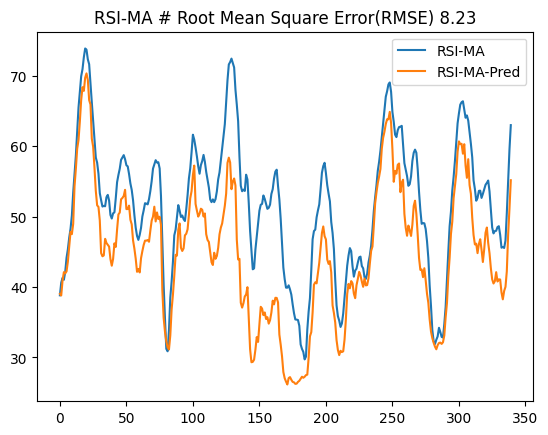

In [22]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [120]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 22 data to predict the new one
(22, 4) [[0.80451077 0.86232142 0.50465915 0.23071577]
 [0.79409869 0.8573104  0.49828347 0.23610146]
 [0.82519925 0.85585329 0.49632173 0.26963169]
 [0.85724945 0.85773687 0.50318784 0.29499653]
 [0.87573342 0.86129078 0.51839137 0.33443363]
 [0.88743429 0.86566209 0.54095145 0.3900278 ]
 [0.88699339 0.8695714  0.56743502 0.45066018]
 [0.90462947 0.87490227 0.59784208 0.49791522]
 [0.88499237 0.8777454  0.62726827 0.50990271]
 [0.90768187 0.88257872 0.65767533 0.52449618]
 [0.91514329 0.88769635 0.68906327 0.53648367]
 [0.9260641  0.89341815 0.72143207 0.55489924]
 [0.94519247 0.90049044 0.75527219 0.57314107]
 [0.93552654 0.90592793 0.787641   0.59763725]
 [0.91158216 0.90848674 0.8131437  0.58947186]
 [0.91592335 0.91118772 0.83374203 0.57974288]
 [0.92908258 0.9149904  0.85139774 0.57244614]
 [0.90951331 0.91644751 0.86365866 0.53874218]
 [0.8942174  0.91626981 0.86905346 0.50191105]
 [0.9018484  0.91683844 0.87052477 0.49027102]
